# Framing the Canon: A Computational Study of Canonicity in Danish Golden Age Paintings (1750-1870)

In [1]:
# import libraries and modules
import os
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset
from datasets import load_dataset
import json
import pickle
import matplotlib.pyplot as plt 
import sys
sys.path.append(os.path.abspath(".."))

# we get a lot of annoying warnings from sklearn so we suppress them
import warnings
warnings.filterwarnings('ignore')

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/Skrivebord/canon-paintings-smk/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

We work with the SMK data in two different formats:

- df: Pandas DataFrame with SMK metadata on paintings and canonicity

- ds: HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [2]:
# load dataset from HuggingFace
ds = load_dataset('chcaa/smk_canon_paintings', split='train') # all the data is in the 'train' split

In [3]:
# we need to download the images from SMK using the links from the 'image_thumbnail' column:
from src.analyses_utils import add_image_col

ds = add_image_col(ds, 'image_thumbnail')

In [4]:
# convert to pandas as it's easier to work with
df = ds.to_pandas()

# inspect dataframe
df.head(5)

smk_id period  start_year                                  title  \
0  KMS8884   1835        1835               Parti af torvet i Amalfi   
1  KMS4313   1870        1870           Leonora Christina i fængslet   
2  KMS3880   1800        1800       Jurisprudensen. Allegorisk figur   
3  KMS7591   1800        1800                             Filosofien   
4  KMS3769   1844        1844  Udsigt fra Athenatemplet på Akropolis   

         first_artist           all_artists  num_artists main_type all_types  \
0     Martinus Rørbye     [Martinus Rørbye]            1    Maleri  [Maleri]   
1  Kristian Zahrtmann  [Kristian Zahrtmann]            1    Maleri  [Maleri]   
2  Nicolai Abildgaard  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
3  Nicolai Abildgaard  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
4     Martinus Rørbye     [Martinus Rørbye]            1    Maleri  [Maleri]   

                                     image_thumbnail  ...  \
0  https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...  ...   
1  https://iip-thumb.smk.dk/iiif/jp2/7d278w98c_KM...  ...   
2  https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...  ...   
3  https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...  ...   
4  https://iip-thumb.smk.dk/iiif/jp2/w0892f396_KM...  ...   

                                 object_history_note  \
0                                               None   
1                                               None   
2  [På auktion efter Abildgaards enke solgt til J...   
3                                               None   
4                                               None   

                                   exhibition_venues smk_exhibitions  \
0  [Petit Palais, Sølvgade, Nationalmuseum, Stock...           canon   
1  [Den Hirschsprungske Samling, Ribe Kunstmuseum...           other   
2  [Louvre, Hamburger Kunsthalle, Sølvgade, Nasjo...           canon   
3  [Louvre, Hamburger Kunsthalle, Sølvgade, Det K...           canon   
4                                               None           other   

                               ex_years exb_canon prod_diff  \
0                    [2020, 2019, 2019]     canon         0   
1  [2006, 2019, 2019, 2020, 2016, 2016]     canon         0   
2  [2008, 2009, 2009, 1992, 1989, 1964]     canon         0   
3              [2008, 2009, 2009, 2001]     canon         0   
4                                  None     other         0   

             prod_notes prod_year total_canons  \
0  [Værkdatering: 1835]      1835        canon   
1  [Værkdatering: 1870]      1870        canon   
2  [Værkdatering: 1800]      1800        canon   
3  [Værkdatering: 1800]      1800        canon   
4  [Værkdatering: 1844]      1844        canon   

                                               image  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  

[5 rows x 45 columns]

## Image embeddings

Image embeddings are obtained by running the scripts 'src/smk_embeddings.py' and 'src/greyscale_embeddings.py'. The pretrained model used is EVA-02-CLIP, a multimodal vision transformer architecture. The embeddings are saved as .npy files in the /data folder but can be found as columns in the dataframe. There's two types of embeddings:
- color embeddings: 'as they are' i.e., embeddings extracted from the downloaded image from SMK
- greyscaled embeddings: all images have been converted to greyscale before extracting embeddings from them

### Create subset of colored images only

Throughout the notebook, we'll work with seperate subsets of colored embeddings and greyscaled embeddings

In [5]:
# make subset of colored images only 
color_subset = df.query('rgb == "color"')
color_idx = color_subset.index.tolist()
ds_color = ds.select(color_idx)
color_subset.reset_index(drop=True, inplace=True)

# Analysis

## Synchronic Comparison

We intially inspect groupings in our data with PCA and dendrograms.

Code is adapted from Feldkamp et al. (2024) (https://aclanthology.org/2024.nlp4dh-1.14/)

#### PCA plots per canon category

Text(0.5, 0.95, 'PCA by canon category')

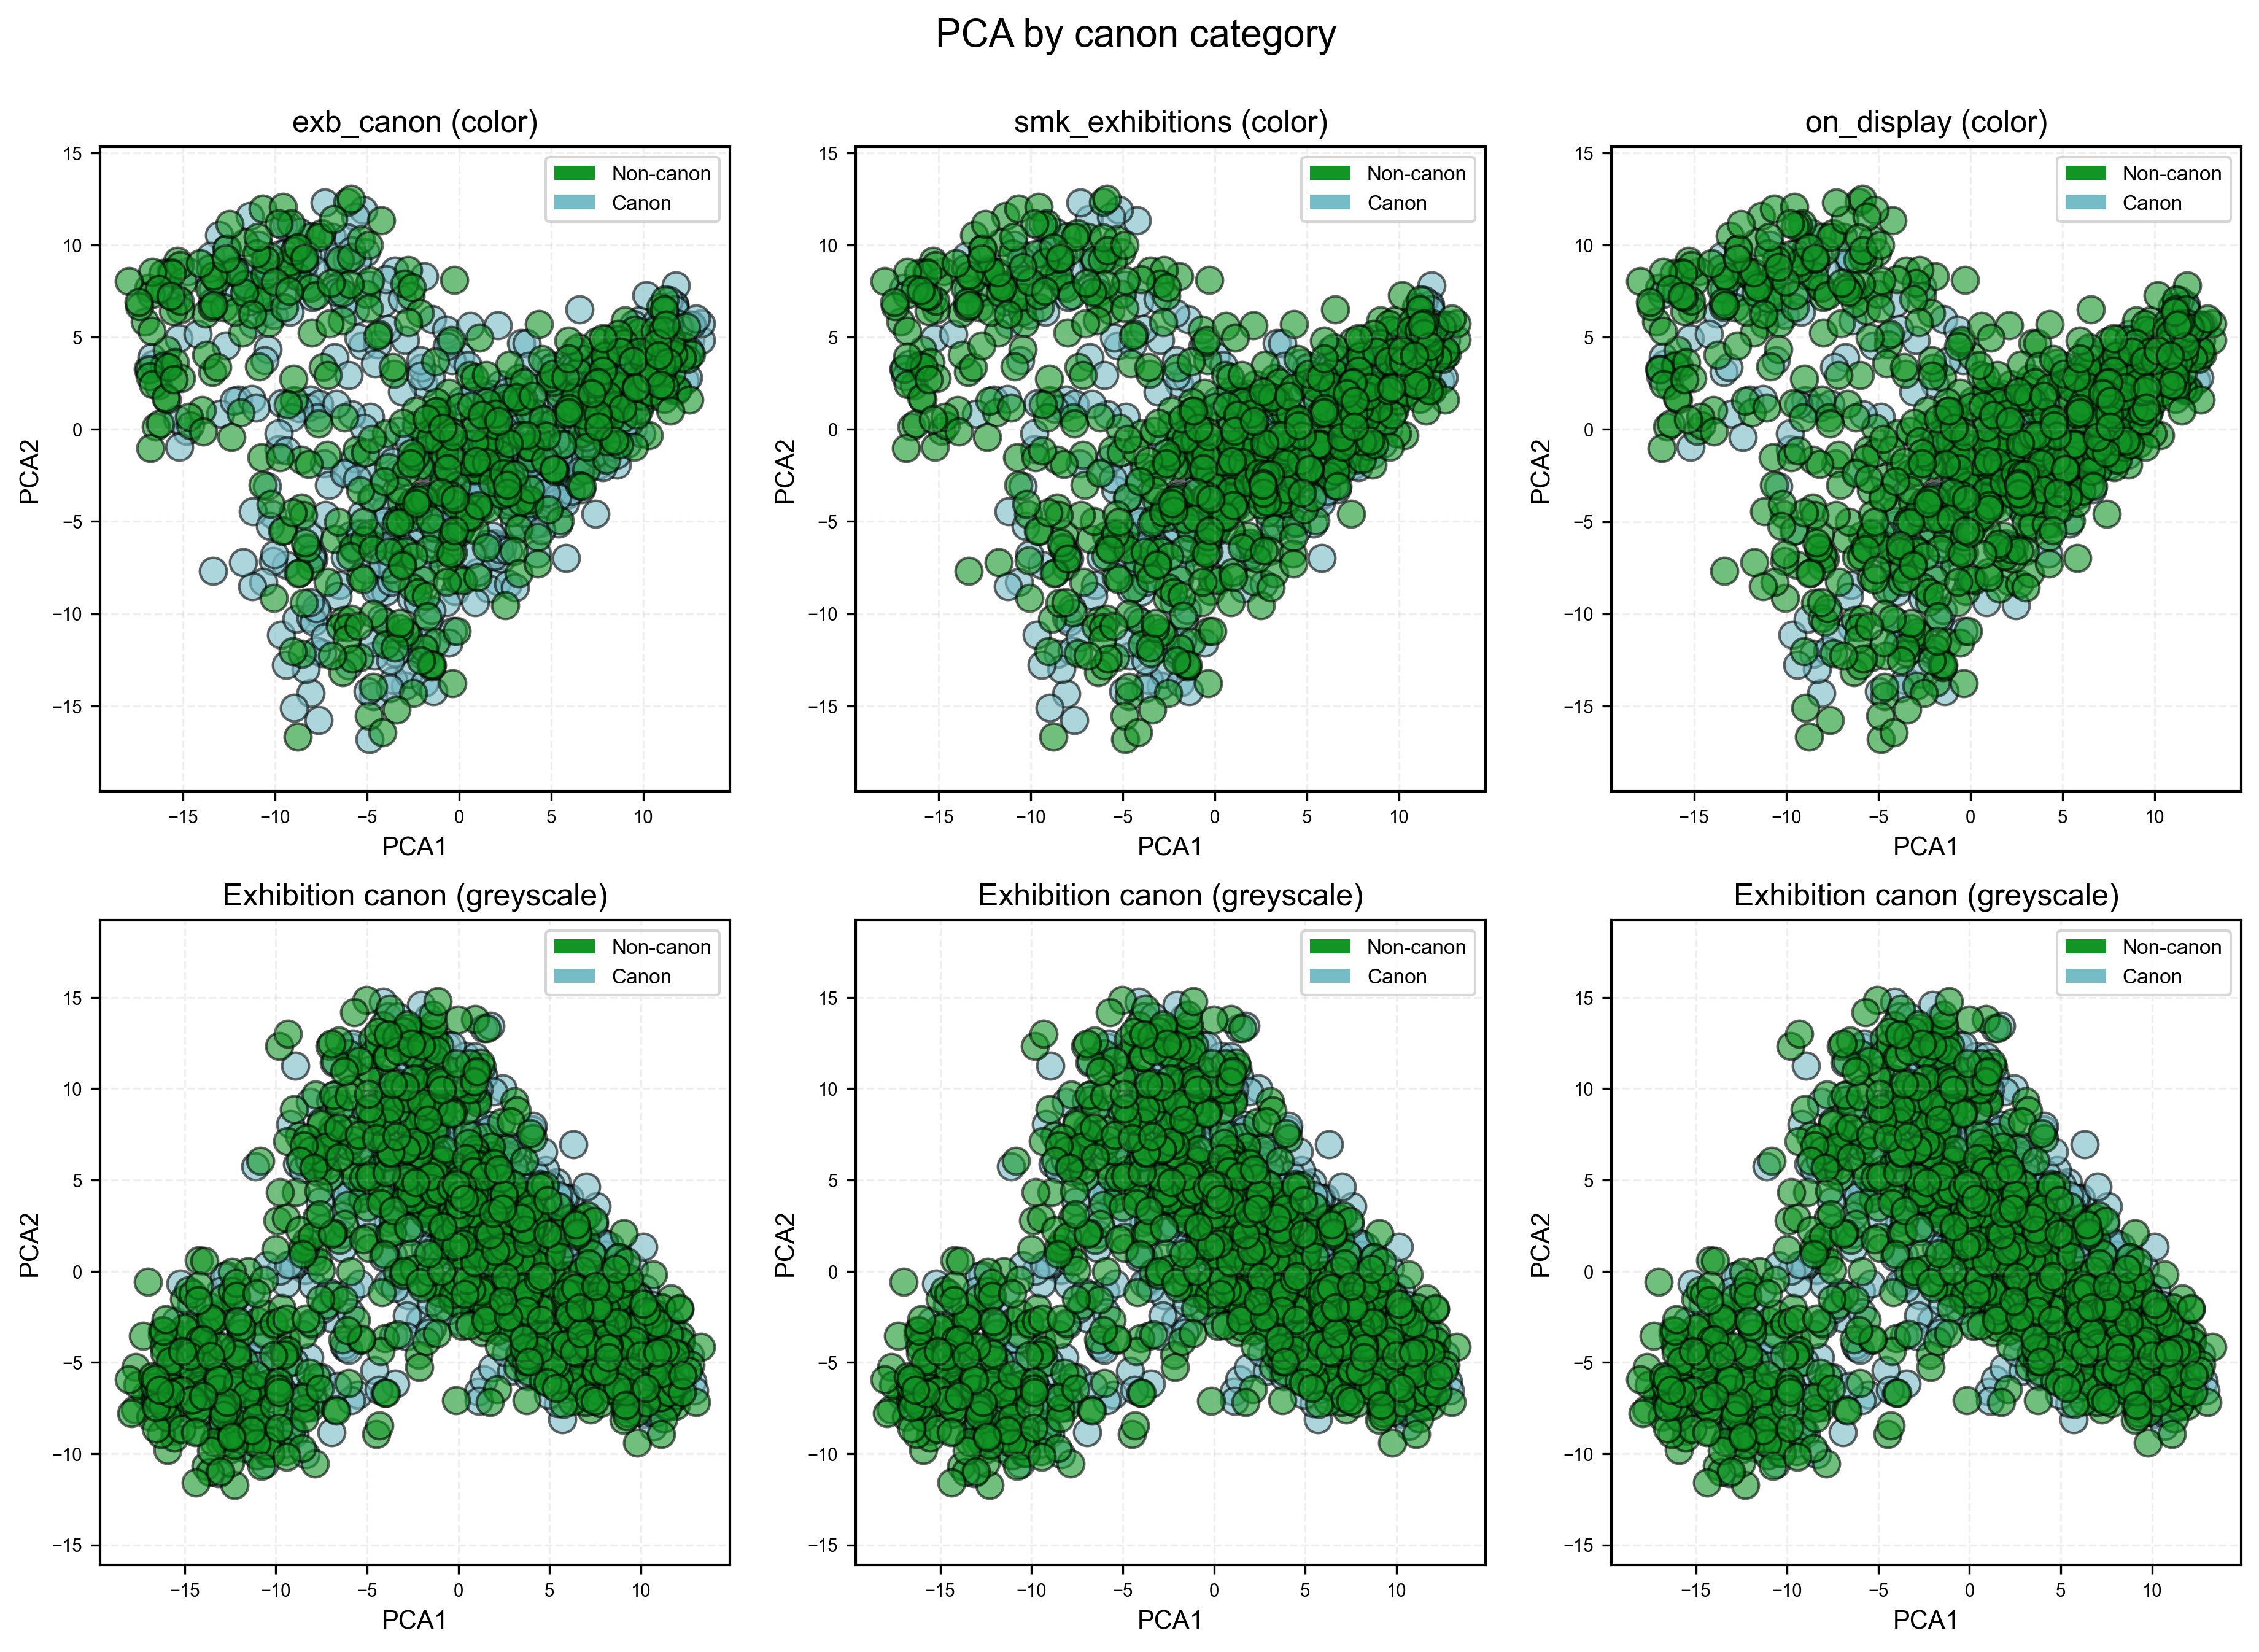

In [6]:
# PCA plots with binary canon variables
from src.analyses_utils import pca_binary
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

canon_cols = ['exb_canon', 'smk_exhibitions', 'on_display']

for idx, col in enumerate(canon_cols):

    pca_binary(ax = axs[0, idx], 
                    df = color_subset, 
                    embedding = 'embedding', 
                    canon_category = col, 
                    title = f"{col} (color)")

    pca_binary(ax = axs[1, idx], 
                    df = df, 
                    embedding = 'grey_embedding', 
                    canon_category = 'exb_canon', 
                    title = "Exhibition canon (greyscale)")

fig.suptitle('PCA by canon category', size = 15, y=0.95)

## Diachronic Change

We inspect temporal changes in embeddings through inter-group (canon vs non-canon) and intra-group (within canon-groups) with cosine similarities of embeddings:

(Code is adapted from Feldkamp et al. (2024) (https://aclanthology.org/2024.nlp4dh-1.14/))

In [7]:
from src.analyses_utils import plot_grid, plot_diachronic_change

#### Intra-group, canon

Plotting canon columns for CANON_COSIM_MEAN: 100%|██████████| 3/3 [01:14<00:00, 24.73s/it]


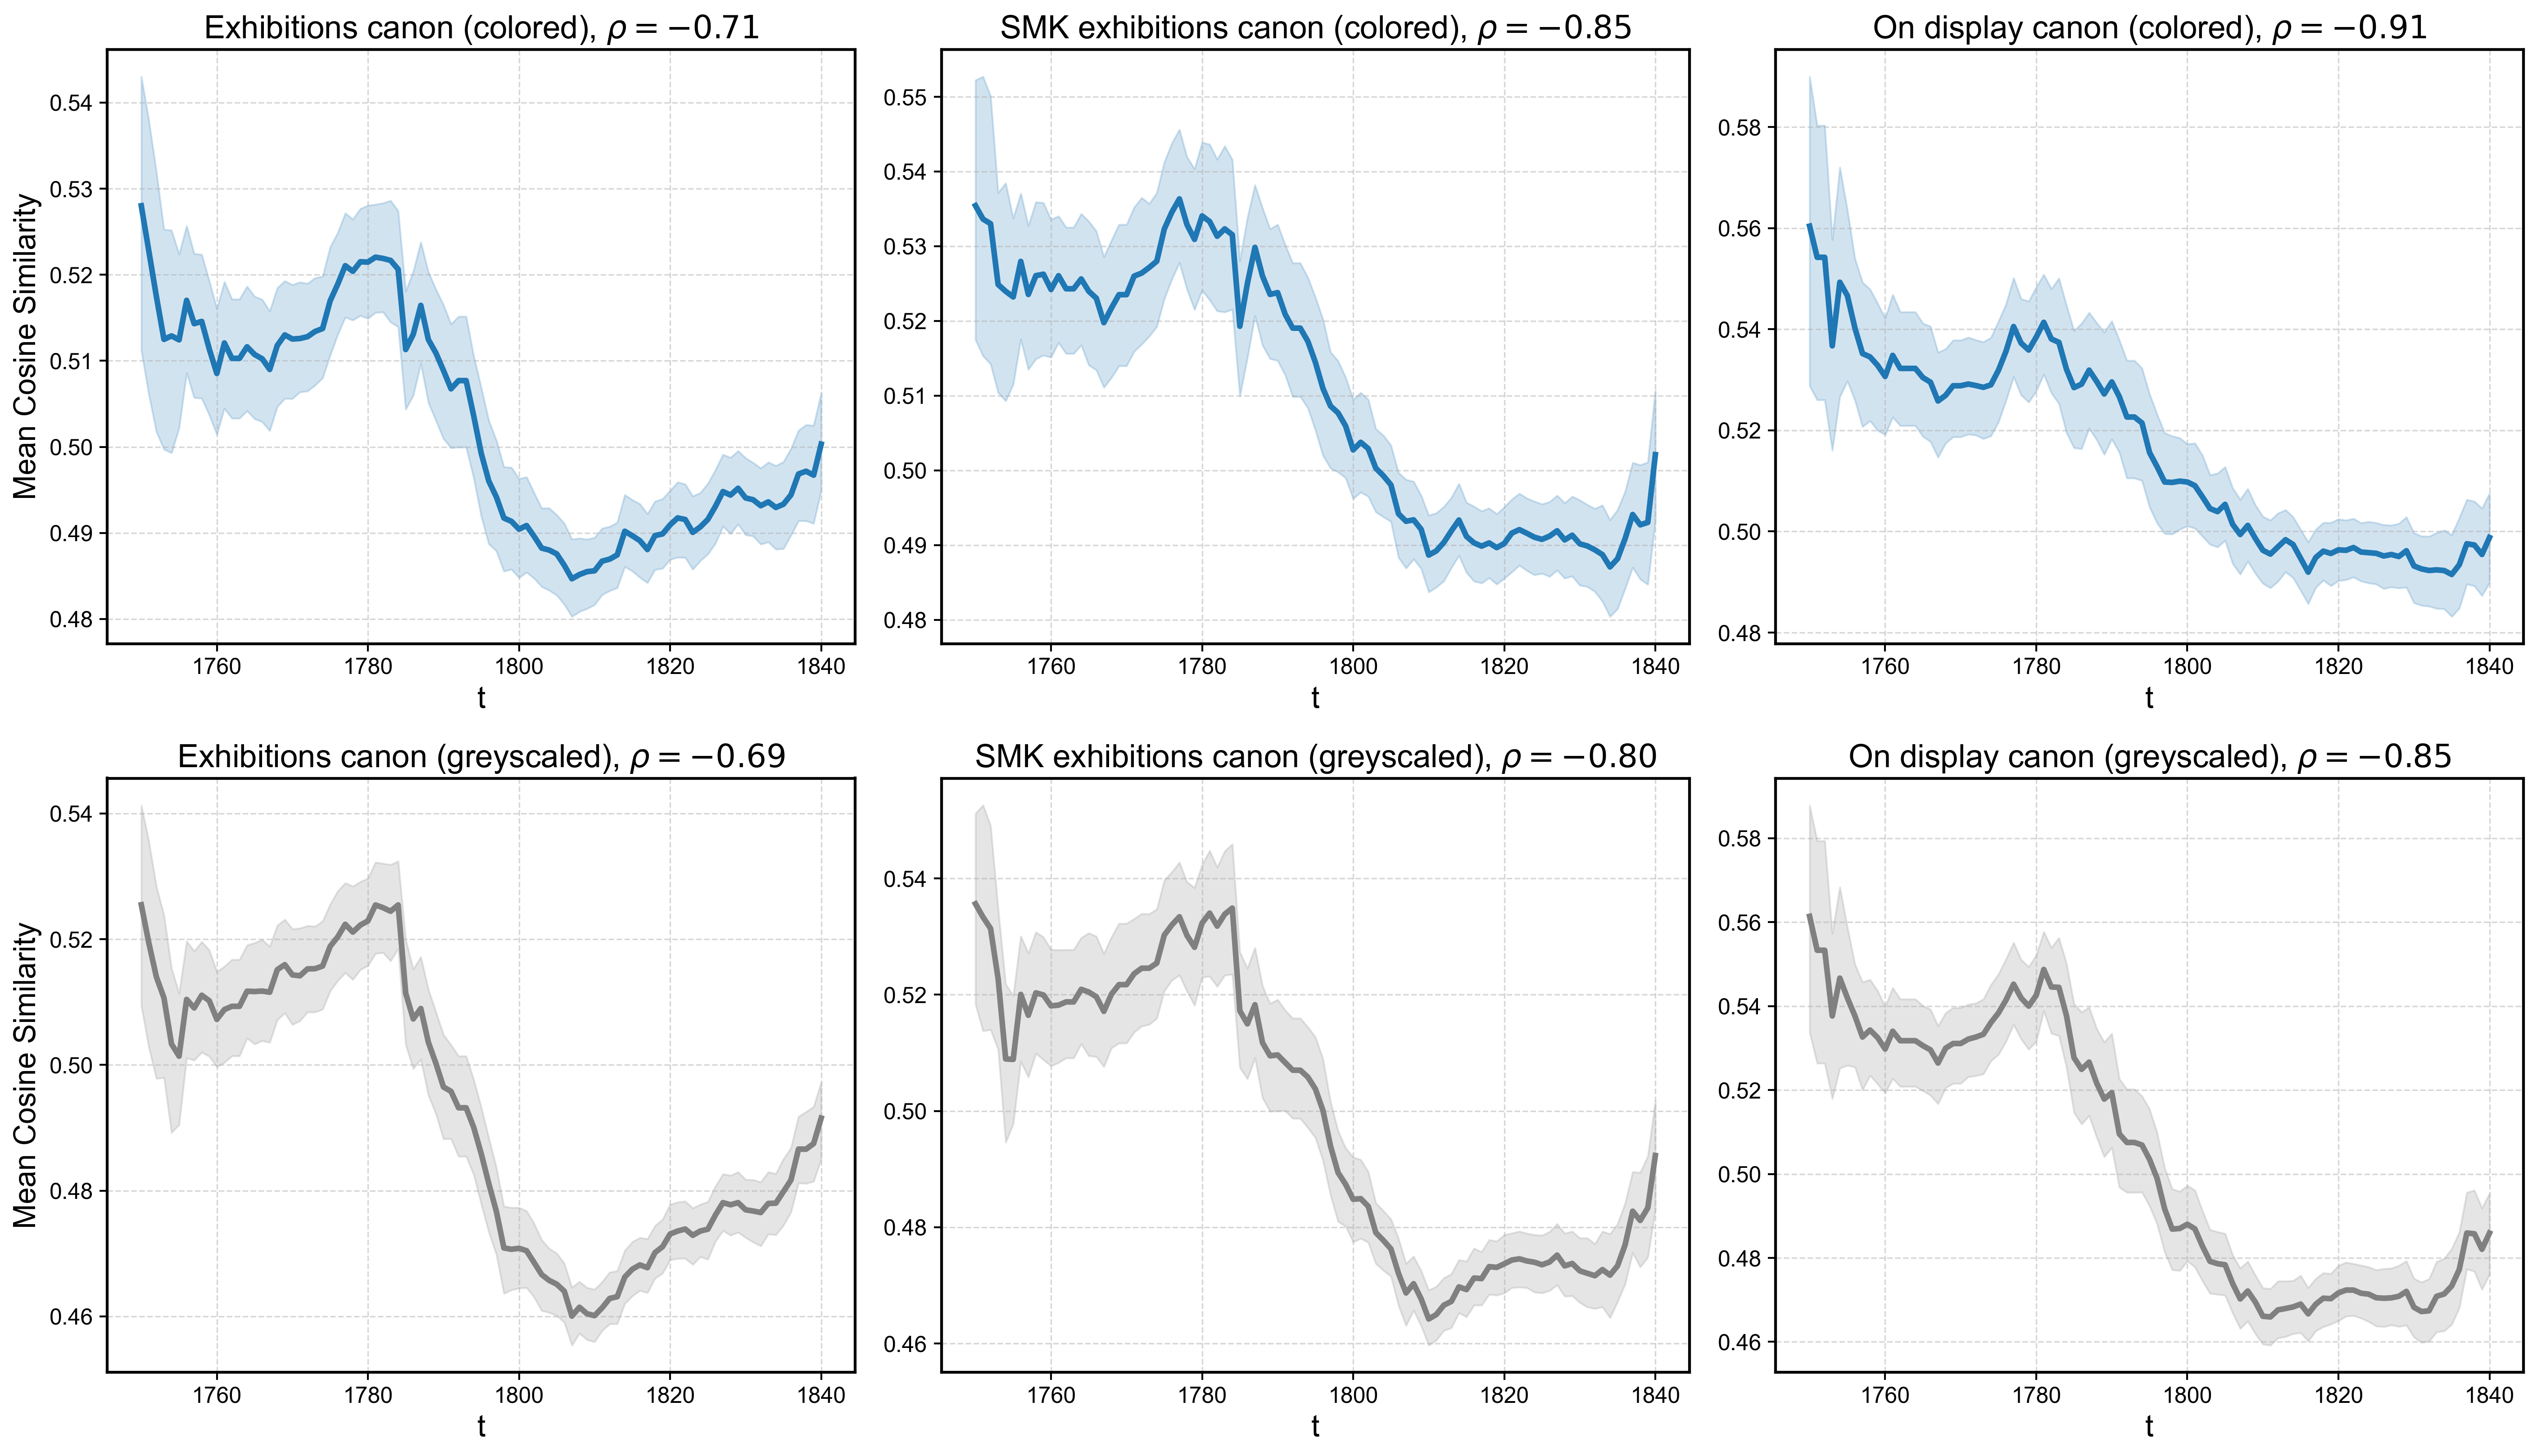

In [8]:
plot_grid(df = df,
           color_subset=color_subset, 
            canon_cols = canon_cols,
            w_size= 30, 
            cosim_to_plot='CANON_COSIM_MEAN', 
            savefig=False,
            filename='')

#### Intra-group, non-canon

Plotting canon columns for NONCANON_COSIM_MEAN: 100%|██████████| 3/3 [01:13<00:00, 24.49s/it]


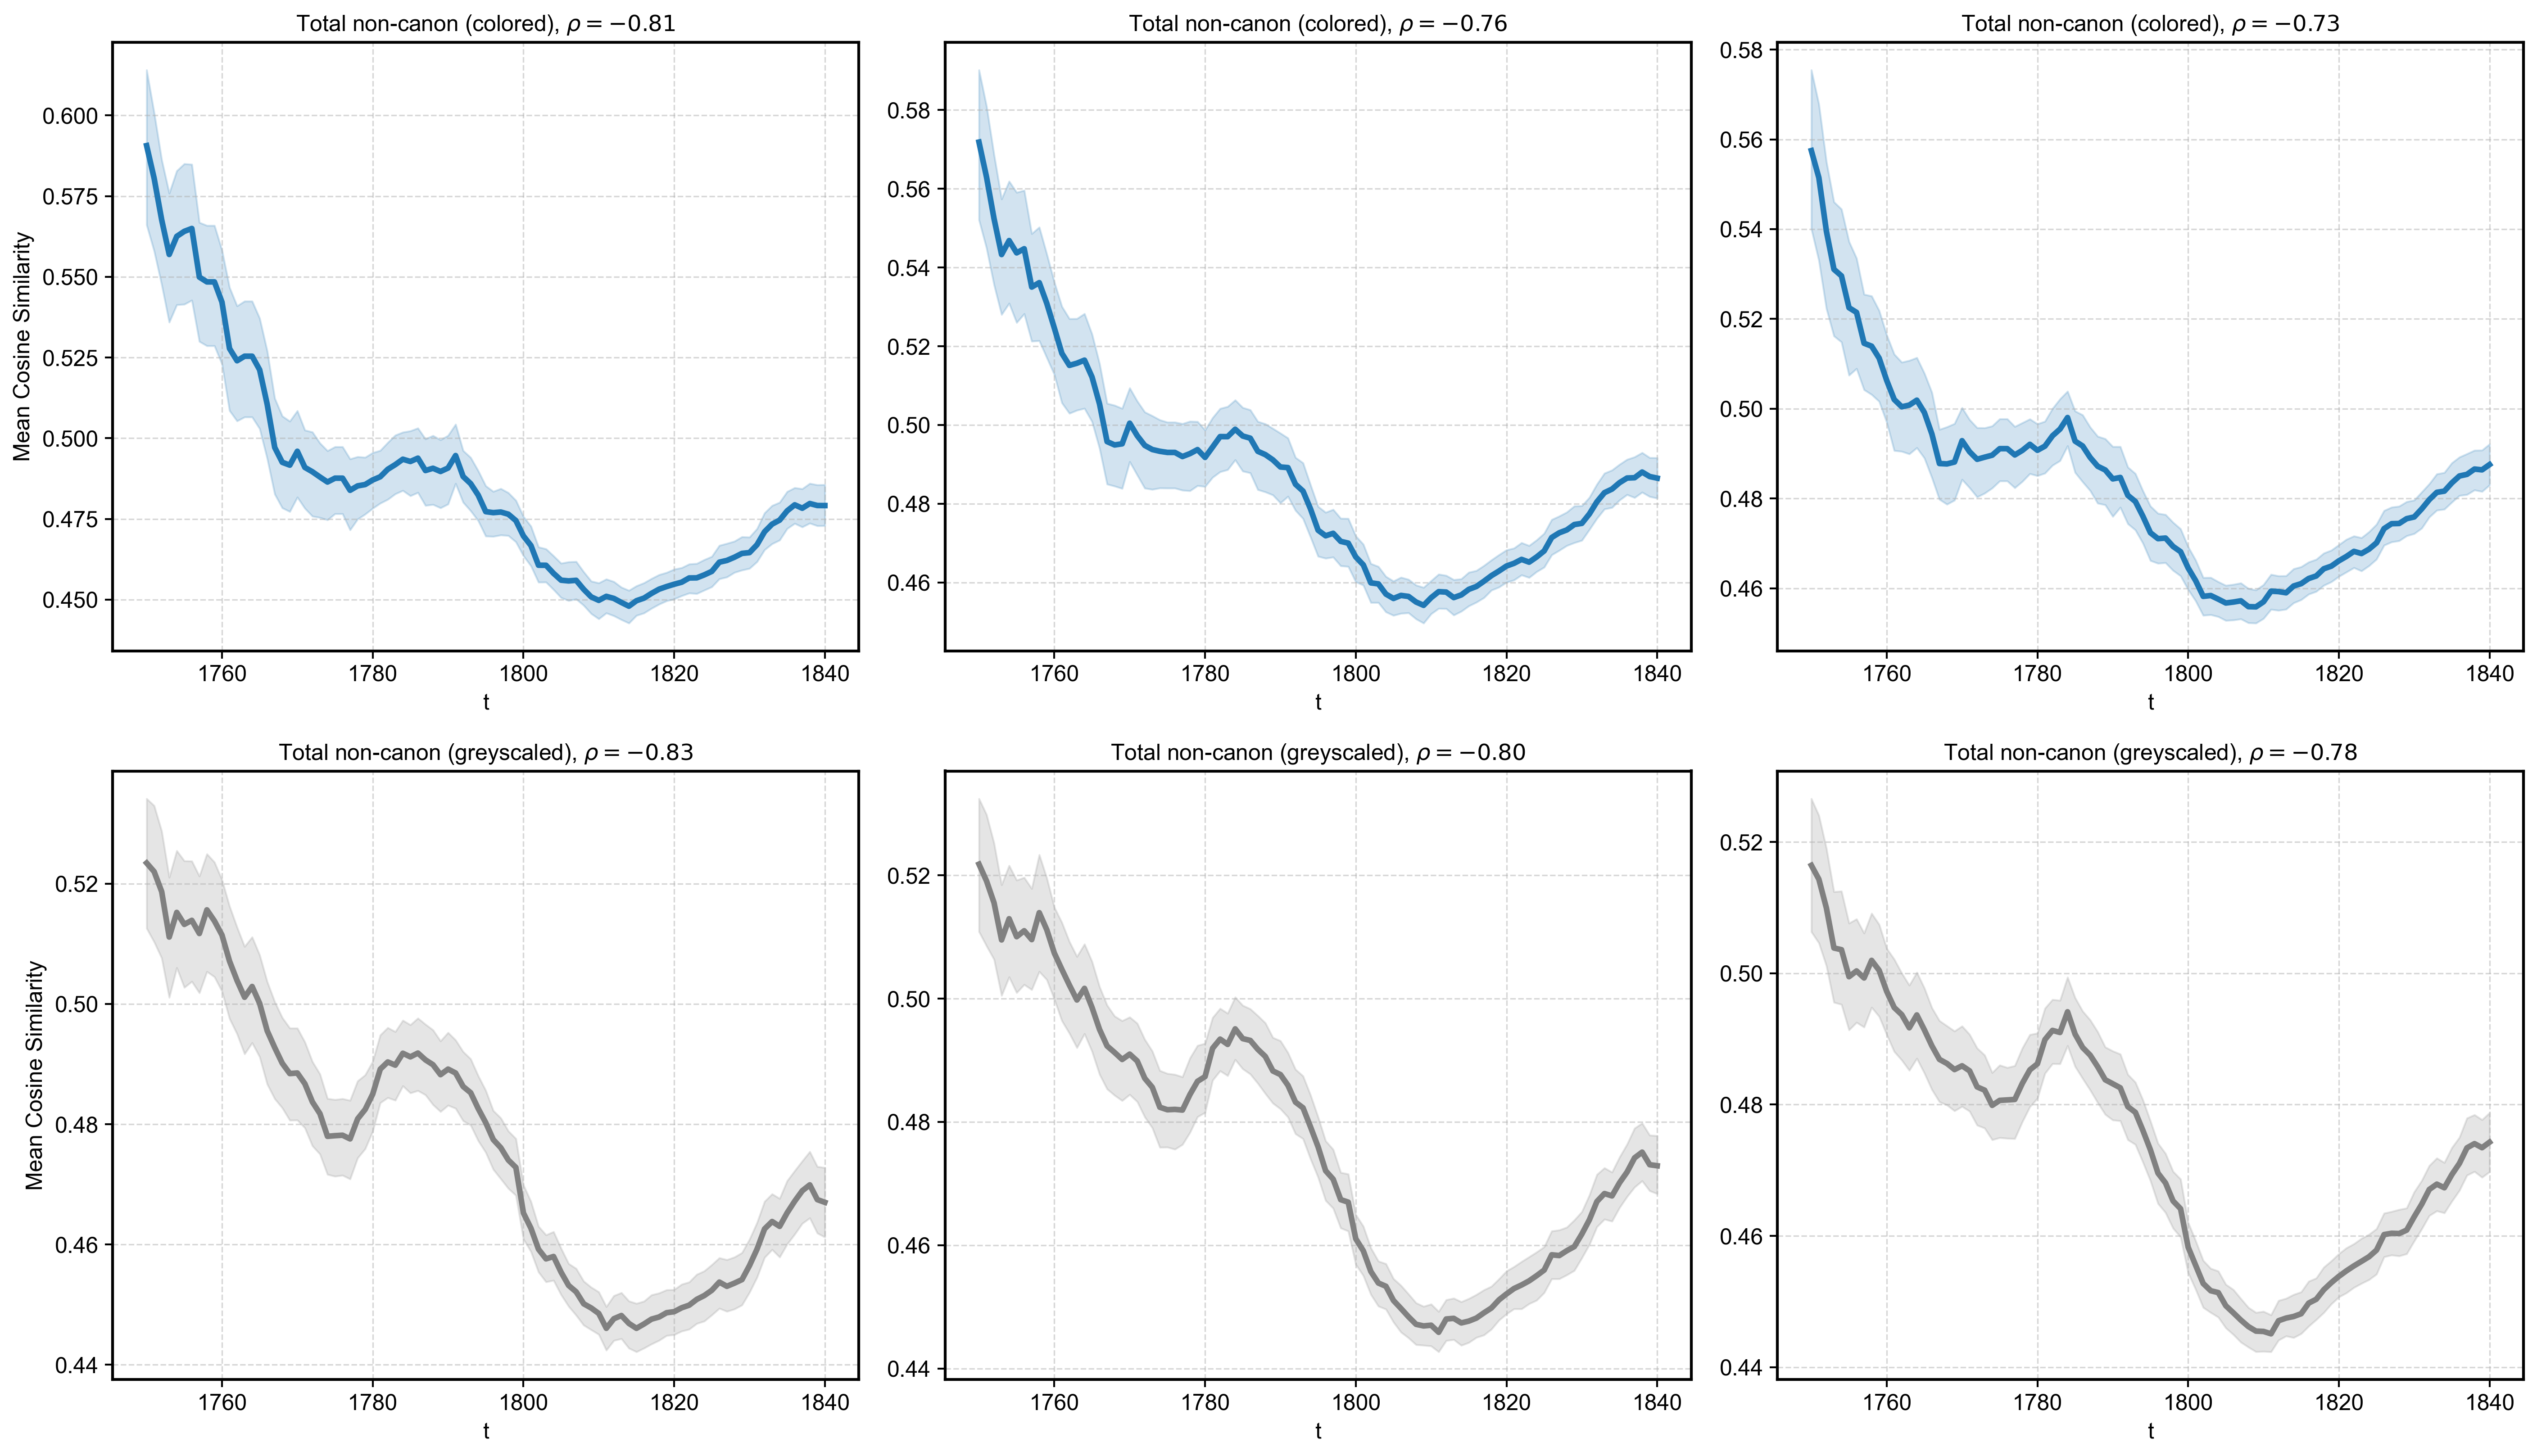

In [9]:
plot_grid(df = df, 
        color_subset = color_subset, 
        canon_cols = canon_cols,
        w_size= 30, 
        cosim_to_plot='NONCANON_COSIM_MEAN',
        savefig=False,
        filename='')

#### Intra-group, total non-canon

Text(0, 0.5, '')

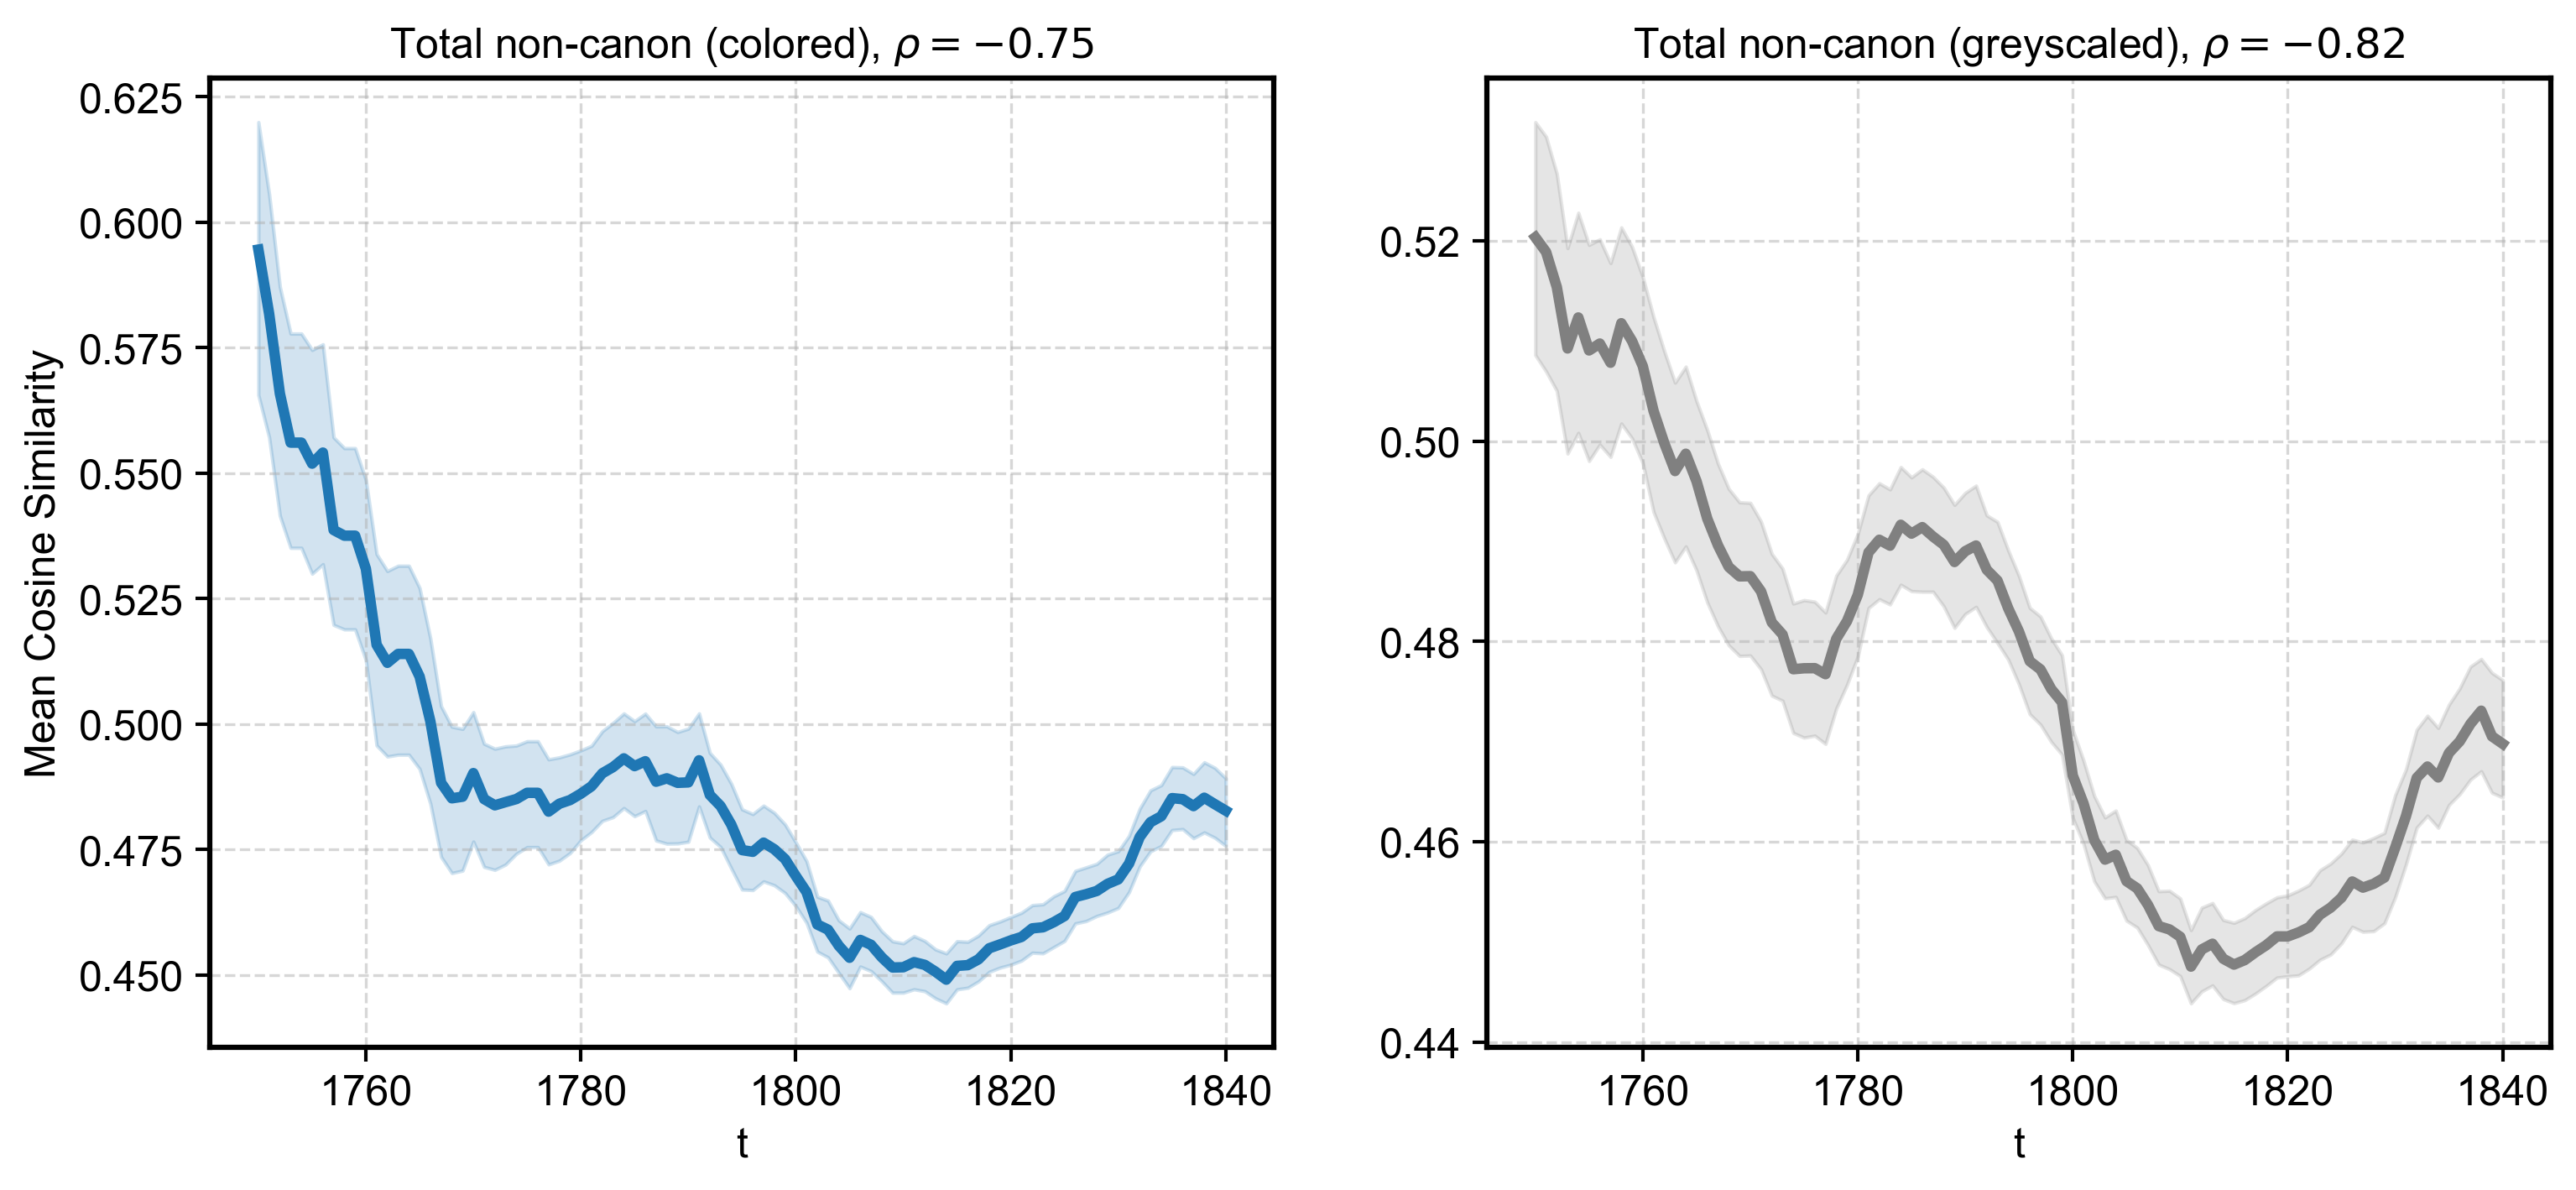

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_diachronic_change(w_size = 30, 
                df = color_subset, 
                canon_col = 'total_canons', 
                embedding_col = 'embedding', 
                cosim_to_plot = 'NONCANON_COSIM_MEAN', 
                ax = axs[0])

plot_diachronic_change(w_size = 30, 
               df = df, 
            canon_col = 'total_canons', 
             embedding_col = 'grey_embedding', 
             cosim_to_plot = 'NONCANON_COSIM_MEAN', 
              ax = axs[1])

    # remove y label from second plot
axs[1].set_ylabel("")

#### Inter-group

Plotting canon columns for CANON_NONCANON_COSIM: 100%|██████████| 3/3 [01:11<00:00, 24.00s/it]


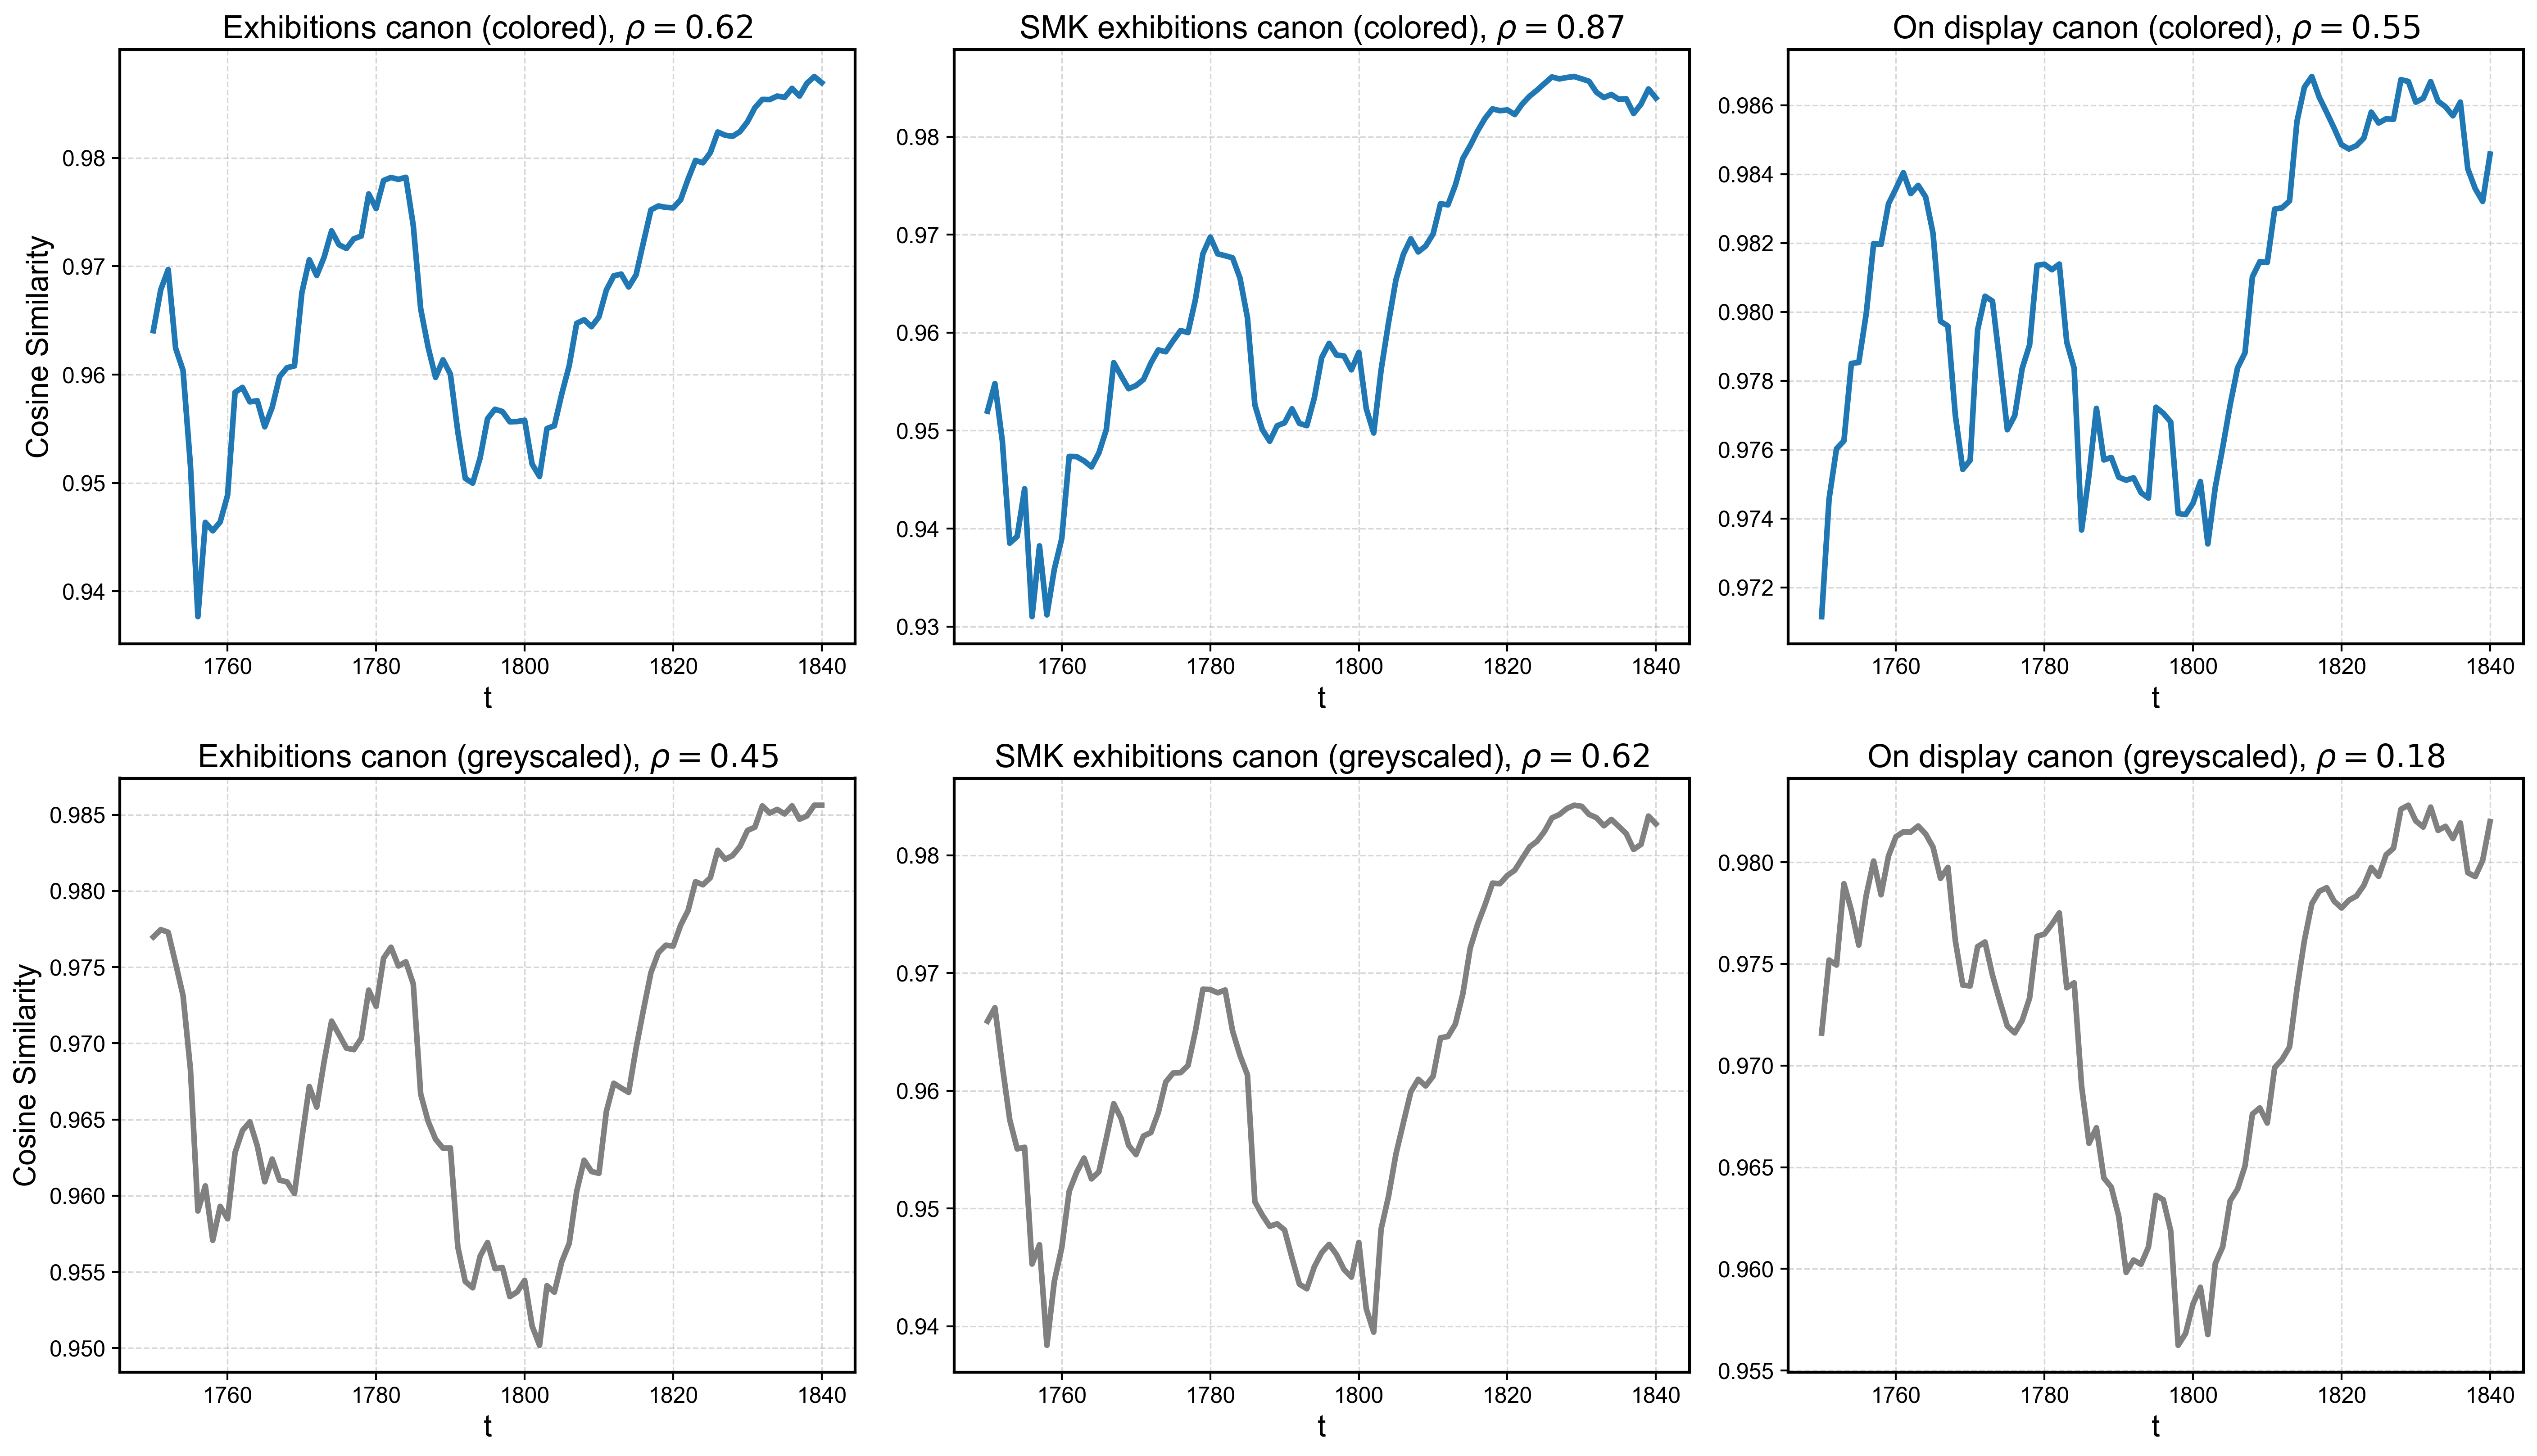

In [12]:
# inter-group
plot_grid(df = df, 
           color_subset = color_subset, 
          canon_cols = canon_cols,
         w_size= 30, 
        cosim_to_plot='CANON_NONCANON_COSIM', 
      savefig=False,
     filename='')

## Classification

The following runs two separate classification models, a Logistic Regression and MLP classifier. Both models are furthermore run with and without balancing the classes

In [13]:
from src.analyses_utils import save_classification_results

In [14]:
models = ['logistic', 'mlp'] # specify models
sampling_methods = [False, True] # do not apply / apply balancing of classes

# run for both greyscale and color data
save_classification_results(canon_cols=canon_cols, 
                                models=models, 
                                sampling_methods=sampling_methods, 
                                df=df, 
                                embedding_col='grey_embedding', 
                                col_or_grey='greyscale',
                                save_report=False)

save_classification_results(canon_cols=canon_cols, 
                                models=models, 
                                sampling_methods=sampling_methods, 
                                df=color_subset, 
                                embedding_col='embedding', 
                                col_or_grey='color',
                                save_report=False)

CLASSIFICATION RESULTS, greyscale (MEAN STRATIFIED 10-FOLD CV MACRO F1 SCORES):
+----------+-----------------+--------------+-------------------+--------------+
|          | unbalanced_logi | balanced_log |  unbalanced_mlp   | balanced_mlp |
|          |      stic       |    istic     |                   |              |
+----------+-----------------+--------------+-------------------+--------------+
| exb_cano | ('Mean: 0.685', | Mean: 0.682, | ('Mean: 0.725', ' | Mean: 0.72,  |
|    n     |   'SD: 0.038')  |   SD: 0.043  |    SD: 0.039')    |   SD: 0.04   |
+----------+-----------------+--------------+-------------------+--------------+
| smk_exhi | ('Mean: 0.659', | Mean: 0.629, | ('Mean: 0.687', ' | Mean: 0.639, |
| bitions  |   'SD: 0.035')  |   SD: 0.027  |    SD: 0.03')     |   SD: 0.026  |
+----------+-----------------+--------------+-------------------+--------------+
| on_displ | ('Mean: 0.64',  | Mean: 0.572, | ('Mean: 0.631', ' | Mean: 0.592, |
|    ay    |  'SD: 0.064')   